In [1]:
# default_exp datasets.generators_legacy

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from nbdev import *
from typing import List, Tuple

In [4]:
# exporti
import numpy as np
import json

In [5]:
#exporti
from PIL import Image, ImageDraw

# Helpers for Dataset Generation

## Use tmp dir

In [6]:
import tempfile
tmp_dir = tempfile.TemporaryDirectory()
tmp_dir.name

'/tmp/tmph40plp7r'

In [7]:
from pathlib import Path

f_path = Path(tmp_dir.name) / 'test.csv'
f_path

Path('/tmp/tmph40plp7r/test.csv')

In [8]:
import pandas as pd
from pandas import DataFrame

DataFrame({'a': [4], 'b': 5}).to_csv(f_path, index=False)
pd.read_csv(f_path)

,a,b
0,4,5


## Create images

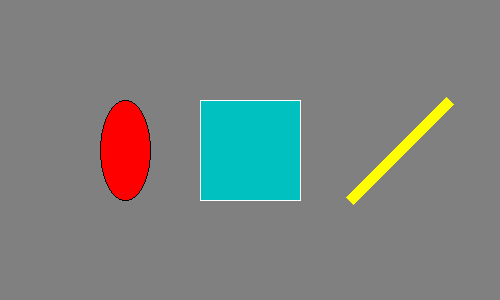

In [9]:
im = Image.new('RGB', (500, 300), (128, 128, 128))
draw = ImageDraw.Draw(im)

draw.ellipse((100, 100, 150, 200), fill=(255, 0, 0), outline=(0, 0, 0))
draw.rectangle((200, 100, 300, 200), fill=(0, 192, 192), outline=(255, 255, 255))
draw.line((350, 200, 450, 100), fill=(255, 255, 0), width=10)
im

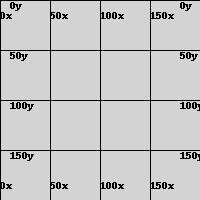

In [10]:
def draw_grid(im=None, size=(100, 100), n_hlines=10, n_vlines=10, black=True):
    """
    size: (width, hight)
    black: bool
         draw grid and numbers in black or white
    """
    color = (0, 0, 0)
    if not black:
        color = (255, 255, 255)
    if im is None:
        im = Image.new('RGB', size, color=(211, 211, 211))
    width, hight = im.size
    draw = ImageDraw.Draw(im)
    ln_width = int((max(size) * 0.03) / max(n_hlines, n_vlines))

    for h in range(n_hlines):
        y = hight * h * (1 / n_hlines)
        draw.line((0, y, width, y), fill=color, width=ln_width)
        draw.text((width * 0.05, y), text=str((int(y))) + 'y',
                  fill=color)
        draw.text((width * 0.9, y), text=str((int(y))) + 'y', fill=color)

    for h in range(n_vlines):
        x = width * h * (1 / n_vlines)
        draw.line((x, 0, x, hight), fill=color, width=ln_width)
        draw.text((x, hight * 0.05), text=str((int(x))) + 'x', fill=color)
        draw.text((x, hight * 0.9), text=str((int(x))) + 'x', fill=color)
    return im


draw_grid(size=(200, 200), n_hlines=4, n_vlines=4)

In [11]:
#exporti

def draw_bbox(rect, im=None, values=True, black=True, width=1):
    """
    rect: [x, y, x, y]
        two points (x, y), (x, y)
    values: bool
        draw values
    black: bool
         draw grid and numbers in black or white
    """
    color = (0, 0, 0)
    if not black:
        color = (255, 255, 255)
    if im is None:
        im = Image.new('RGB', (100, 100), color='grey')

    draw = ImageDraw.Draw(im)
    draw.rectangle(rect, outline=color, width=width)

    if values:
        draw.text((rect[0], rect[1]), text=f"({rect[0]}x, {rect[1]}y)", fill=color)
        draw.text((rect[0], rect[3]), text=f"({rect[0]}x, {rect[3]}y)", fill=color)
        draw.text((rect[2], rect[1]), text=f"({rect[2]}x, {rect[1]}y)", fill=color)
        draw.text((rect[2], rect[3]), text=f"({rect[2]}x, {rect[3]}y)", fill=color)
        draw.text(((rect[0] + rect[2]) / 2, (rect[1] + rect[3]) / 2), text=f"{rect}", fill=color)
    return im

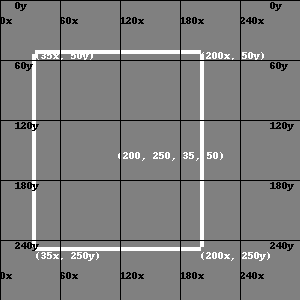

In [12]:
img = Image.new('RGB', (300, 300), color='grey')
# draw_bbox((35, 50, 200, 250), im=img, black=False)
draw_bbox((200, 250, 35, 50), im=img, black=False, width=4)

draw_grid(img, n_hlines=5, n_vlines=5)

In [13]:
#exporti

def xywh_to_xyxy(boxes):
    boxes = np.array(boxes)
    """Convert [x y w h] box format to [x1 y1 x2 y2] format."""
    return np.hstack((boxes[0:2], boxes[0:2] + boxes[2:4])).tolist()


def xyxy_to_xywh(boxes):
    boxes = np.array(boxes)
    """Convert [x1 y1 x2 y2] box format to [x y w h] format."""
    return np.hstack((boxes[0:2], boxes[2:4] - boxes[0:2])).tolist()

In [14]:
xyxy_to_xywh([50, 50, 150, 150])

[50, 50, 100, 100]

In [15]:
xywh_to_xyxy([50, 50, 100, 100])

[50, 50, 150, 150]

## Overlap & Intersection over Union (IOU)

In [16]:
#exporti
def bbox_intersection(b1, b2):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(b1[0], b2[0])
    yA = max(b1[1], b2[1])
    xB = min(b1[2], b2[2])
    yB = min(b1[3], b2[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # compute the area of both the prediction and ground-truth
    # rectangles

    b1Area = (b1[2] - b1[0]) * (b1[3] - b1[1])
    b2Area = (b2[2] - b2[0]) * (b2[3] - b2[1])
    return interArea, b1Area, b2Area, (xA, yA, xB, yB)

In [17]:
#exporti
def overlap(boxA, boxB, verbose=False):
    """
    Returns the max relative overlap between two bboxs.
    """

    interArea, boxAArea, boxBArea, _ = bbox_intersection(boxA, boxB)
    return max(interArea / float(boxAArea), interArea / float(boxBArea))

In [18]:
r1 = (10, 10, 110, 110)
r2 = (50, 50, 90, 90)
assert overlap(r1, r2) == 1
assert overlap(r2, r1) == 1

In [19]:
r1 = (0, 0, 100, 100)
r2 = (50, 50, 150, 150)
assert overlap(r1, r2) == 0.25
assert overlap(r2, r1) == 0.25

In [20]:
# export

def bb_intersection_over_union(boxA, boxB, verbose=False):

    interArea, boxAArea, boxBArea, _ = bbox_intersection(boxA, boxB)

    iou = interArea / float(boxAArea + boxBArea - interArea)
    if verbose:
        print(f"iou: {iou: .2f}, interArea: {interArea: .2f}"
              f", boxAArea {boxAArea: .2f}, box1Area {boxBArea: .2f}")
    return iou

iou:  0.05, interArea:  900.00, boxAArea  10000.00, box1Area  10000.00


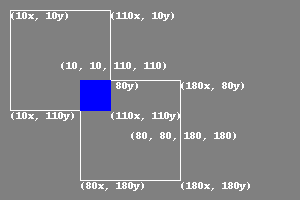

In [21]:
r1 = (10, 10, 110, 110)
r2 = (80, 80, 180, 180)
img = Image.new('RGB', (300, 200), color='grey')
draw_bbox(r1, im=img, black=False, values=True)
draw_bbox(r2, im=img, black=False, values=True)


iou = bb_intersection_over_union(r1, r2, verbose=True)
# iou = bb_intersection_over_union(r1, r2, verbose=True)
_, _, _, union = bbox_intersection(r1, r2)
draw = ImageDraw.Draw(img)
draw.rectangle(union, fill='blue')
img

iou:  0.68, interArea:  8100.00, boxAArea  10000.00, box1Area  10000.00


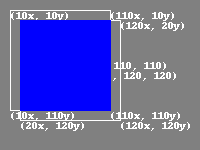

In [22]:
r1 = (10, 10, 110, 110)
r2 = (20, 20, 120, 120)
img = Image.new('RGB', (200, 150), color='grey')
draw_bbox(r1, im=img, black=False, values=True)
draw_bbox(r2, im=img, black=False, values=True)

iou = bb_intersection_over_union(r1, r2, verbose=True)
_, _, _, union = bbox_intersection(r1, r2)
draw = ImageDraw.Draw(img)
draw.rectangle(union, fill='blue')
img

iou:  1.00, interArea:  10000.00, boxAArea  10000.00, box1Area  10000.00


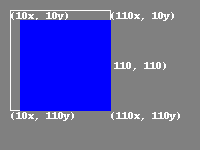

In [23]:
r1 = (10, 10, 110, 110)
img = Image.new('RGB', (200, 150), color='grey')
draw_bbox(r1, im=img, black=False, values=True)
draw_bbox(r1, im=img, black=False, values=True)

iou = bb_intersection_over_union(r1, r1, verbose=True)
_, _, _, union = bbox_intersection(r1, r2)
draw = ImageDraw.Draw(img)
draw.rectangle(union, fill='blue')
img

iou:  0.49, interArea:  4900.00, boxAArea  10000.00, box1Area  4900.00


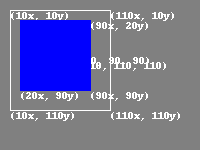

In [24]:
r1 = (10, 10, 110, 110)
r2 = (20, 20, 90, 90)
img = Image.new('RGB', (200, 150), color='grey')
draw_bbox(r1, im=img, black=False, values=True)
draw_bbox(r2, im=img, black=False, values=True)

iou = bb_intersection_over_union(r1, r2, verbose=True)
_, _, _, union = bbox_intersection(r1, r2)
draw = ImageDraw.Draw(img)
draw.rectangle(union, fill='blue')
img

## Sample Random bbox

In [25]:
#exporti
def sample_bbox(bboxs=(), canvas_size=(100, 100), diag=(0.3, 0.3), ratio=(1, 1),
                max_iou=0.0, max_overlap=0.0,
                max_tries=1000, random_seed=None):
    """
    bboxs: [(x, y, x, y), ..., (x, y, x, y)]
            List of existing bboxs.
    canvas_size: (int, int)
           Size of the canvas (width, height) on which to position the new bbox.
    max_iou: float [0, 1]
            Maximum acceptable intersection over union between any two bboxs.
    max_overlap: float [0, 1]
            Maximum overlap between any two bboxs.
    diag: (float, float) or float
            Range of acceptable diagonal lenght relative to canvas diagonal.
    ratio: (float, float) or float
            Range of acceptable width / height ratios of the new bbox.
    max_tries: int
            Number of random tries to create a valid bbox
    """
#     for v in [diag, ratio]: assert min(v) >= 0 and max(v) <= 1, f"{v} is outside of (0, 1)"

    width, height = canvas_size
    canvas_diag = np.sqrt(width ** 2 + height**2)

    for i in range(max_tries):
        s_diag = np.random.uniform(*diag) * canvas_diag
        s_ratio = np.random.uniform(*ratio)

        # sample position fully inside canvas
        s_height = np.sqrt(s_diag ** 2 / (1. + s_ratio ** 2))
        s_width = s_ratio * s_height

        cx = np.random.randint(s_width / 2, width - s_width / 2)
        cy = np.random.randint(s_height / 2, height - s_height / 2)

        bbox = (cx - s_width / 2, cy - s_height / 2, cx + s_width / 2, cy + s_height / 2)
        bbox = tuple(int(v) for v in bbox)

        # check if valid iou then return
        if len(bboxs) == 0:
            return bbox
        violation = False
        for b in bboxs:
            iou = bb_intersection_over_union(b, bbox)
            b_overlap = overlap(b, bbox)
            if iou > max_iou or b_overlap > max_overlap:
                violation = True
        if not violation:
            return bbox

    return None

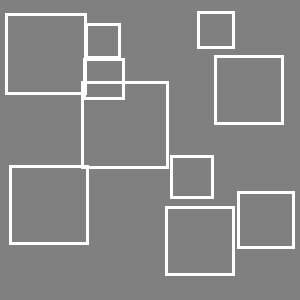

In [26]:
canvas_size = (300, 300)
img = Image.new('RGB', canvas_size, color='grey')

bboxs: List[Tuple[int, int, int, int]] = []
for i in range(10):
    bbox = sample_bbox(bboxs=bboxs, canvas_size=canvas_size, diag=(0.1, 0.3),
                       max_iou=0.3, max_overlap=0.5)
    bboxs.append(bbox)
    draw_bbox(bbox, im=img, black=False, values=False, width=3)
img

## Draw Objects inside bbox

In [27]:
#exporti
def draw_rectangle(im, bbox, color):
    draw = ImageDraw.Draw(im)
    draw.rectangle(bbox, fill=color)

In [28]:
#exporti
def draw_ellipse(im, bbox, color):
    draw = ImageDraw.Draw(im)
    draw.ellipse(bbox, fill=color)

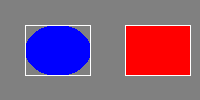

In [29]:
img = Image.new('RGB', (200, 100), color='grey')
bbox1 = (25, 25, 90, 75)
bbox2 = (125, 25, 190, 75)
draw_ellipse(img, bbox1, "blue")
draw_rectangle(img, bbox2, "red")
draw_bbox(bbox1, im=img, black=False, values=False)
draw_bbox(bbox2, im=img, black=False, values=False)
img

# Create Object Detection Dataset

## Generic Dataset

In [30]:
# exporti
def create_simple_object_detection_dataset(path, n_samples=100, n_shapes=2, n_colors=3,
                                           n_objects=(1, 3), size=(150, 150), label_noise=0):

    (path / 'images').mkdir(parents=True, exist_ok=True)
    red = (255, 0, 0)
    blue = (0, 192, 192)
    yellow = (255, 255, 0)
    color = [red, blue, yellow]
    cname = ['red', 'blue', 'yellow']
    draw_shape = [draw_ellipse, draw_rectangle]
    shape = ['ellipse', 'rectangle']
    bg_color = (211, 211, 211)  # light grey
    assert n_shapes > 0 and n_shapes <= 2, (f"n_shapes:{n_shapes} but only max 2"
                                            f"shapes are supported.")
    assert n_colors > 0 and n_colors <= 3, (f"n_shapes:{n_colors} but only max 3"
                                            f"colors are supported.")

    # create class labels
    (path / 'class_images').mkdir(parents=True, exist_ok=True)
    for clr, name in zip(color, cname):
        img_name = f'{name}.jpg'
        img = Image.new('RGB', (50, 50), color=bg_color)
        draw_rectangle(img, bbox=(0, 0, 50, 50), color=clr)
        img.save(path / 'class_images' / img_name)

    # create images + annotations
    bbox_sample_failed = 0
    annotations = {}
    with open(path / 'annotations.json', 'w') as f:
        for i in range(n_samples):

            img_name = f'img_{i}.jpg'
            img = Image.new('RGB', size, color=bg_color)

            bboxs, labels = [], []
            for o in range(np.random.randint(n_objects[0], n_objects[1] + 1)):

                # sample bbox
                bbox = sample_bbox(bboxs=bboxs, canvas_size=size, diag=(0.2, 0.5), ratio=(0.5, 2.),
                                   max_iou=0.0, max_overlap=0.0, max_tries=1000, random_seed=None)

                if bbox is None:
                    bbox_sample_failed += 1
                    continue
                bboxs.append(bbox)

                # sample color
                c = np.random.randint(0, n_colors)

                # sample shape
                s = np.random.randint(0, n_shapes)
                draw_shape[s](img, bbox, cname[c])

                labels.append((cname[c], shape[s]))

            img.save(path / 'images' / img_name)

            annotations[img_name] = {'labels': labels, 'bboxs': bboxs}
        json.dump(annotations, f)
    if bbox_sample_failed > 0:
        import warnings
        warnings.warn(f"{bbox_sample_failed} bbox have been failed to create."
                      " You can increase max_tries or reduce the number and size"
                      " of objects per image.")

                                                      labels  \
img_0.jpg  [[red, rectangle], [yellow, ellipse], [yellow,...   
img_1.jpg  [[blue, rectangle], [red, ellipse], [red, elli...   
img_2.jpg                                 [[red, rectangle]]   
img_3.jpg           [[blue, rectangle], [yellow, rectangle]]   
img_4.jpg                                 [[red, rectangle]]   

                                                       bboxs  
img_0.jpg  [[69, 29, 134, 110], [2, 61, 45, 108], [48, 11...  
img_1.jpg  [[51, 8, 94, 89], [108, 69, 137, 108], [12, 95...  
img_2.jpg                               [[19, 112, 72, 145]]  
img_3.jpg             [[31, 125, 68, 148], [34, 22, 91, 57]]  
img_4.jpg                                [[92, 15, 139, 42]]  


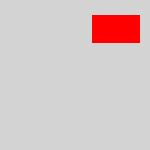

In [31]:
import tempfile
tmp_dir = tempfile.TemporaryDirectory()
path = Path(tmp_dir.name)
create_simple_object_detection_dataset(path=path, n_samples=5)
print(pd.read_json(path / 'annotations.json').T)

Image.open(list(path.glob('**/images/*'))[2])

## Specific Tasks

In [32]:
#export
def create_color_classification(path, n_samples=10, n_colors=3, size=(150, 150)):
    create_simple_object_detection_dataset(path=path, n_objects=(1, 1), n_samples=n_samples,
                                           n_colors=n_colors, size=size)
    with open(path / 'annotations.json', 'r') as f:
        annotations = json.load(f)
    # simplify by dropping mutli-label and bbox
    annotations = {k: {'labels': v['labels'][0][0]} for k, v in annotations.items()}
    with open(path / 'annotations.json', 'w') as f:
        json.dump(annotations, f)

           labels
img_0.jpg     red
img_1.jpg     red
img_2.jpg     red
img_3.jpg    blue
img_4.jpg  yellow
img_5.jpg     red
img_6.jpg     red
img_7.jpg  yellow
img_8.jpg    blue
img_9.jpg  yellow


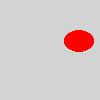

In [33]:
import tempfile
tmp_dir = tempfile.TemporaryDirectory()
path = Path(tmp_dir.name)
create_color_classification(path, size=(100, 100))
print(pd.read_json(path / 'annotations.json').T)
Image.open(list(path.glob('**/images/*'))[2])

In [34]:
#export
def create_shape_color_classification(path, n_samples=10, n_colors=3, size=(150, 150)):
    create_simple_object_detection_dataset(path=path, n_objects=(1, 1), n_samples=n_samples,
                                           n_colors=n_colors, size=size)
    with open(path / 'annotations.json', 'r') as f:
        annotations = json.load(f)
    # simplify by dropping mutli-label and bbox
    annotations = {k: {'labels': v['labels'][0]} for k, v in annotations.items()}
    with open(path / 'annotations.json', 'w') as f:
        json.dump(annotations, f)

                        labels
img_0.jpg    [yellow, ellipse]
img_1.jpg     [red, rectangle]
img_2.jpg    [yellow, ellipse]
img_3.jpg      [blue, ellipse]
img_4.jpg       [red, ellipse]
img_5.jpg    [yellow, ellipse]
img_6.jpg      [blue, ellipse]
img_7.jpg      [blue, ellipse]
img_8.jpg  [yellow, rectangle]
img_9.jpg    [blue, rectangle]


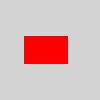

In [35]:
import tempfile
tmp_dir = tempfile.TemporaryDirectory()
path = Path(tmp_dir.name)
create_shape_color_classification(path, size=(100, 100))
print(pd.read_json(path / 'annotations.json').T)
Image.open(list(path.glob('**/images/*'))[2])

In [36]:
#export
def create_object_detection(path, n_samples=10, n_objects=(1, 1), n_colors=3,
                            size=(150, 150), multilabel=False):
    create_simple_object_detection_dataset(path=path, n_objects=n_objects, n_samples=n_samples,
                                           n_colors=n_colors, size=size)
    with open(path / 'annotations.json', 'r') as f:
        annotations = json.load(f)

    # simplify by dropping mutli-label and bbox
    if max(n_objects) == 1:
        annotations = {k: {
            'labels': v['labels'][0], 'bbox': v['bboxs'][0]} for k, v in annotations.items()}
        if not multilabel:
            for k, v in annotations.items():
                v['labels'] = v['labels'][0]
    else:
        if not multilabel:
            for k, v in annotations.items():
                v['labels'] = v['labels'] = [label[0] for label in v['labels']]
    with open(path / 'annotations.json', 'w') as f:
        json.dump(annotations, f)

                                                      labels  \
img_0.jpg         [[yellow, rectangle], [yellow, rectangle]]   
img_1.jpg           [[yellow, rectangle], [yellow, ellipse]]   
img_2.jpg                                [[yellow, ellipse]]   
img_3.jpg  [[blue, ellipse], [blue, rectangle], [yellow, ...   
img_4.jpg  [[blue, rectangle], [blue, rectangle], [blue, ...   
img_5.jpg                                [[yellow, ellipse]]   
img_6.jpg  [[red, ellipse], [red, rectangle], [yellow, el...   
img_7.jpg                                  [[blue, ellipse]]   
img_8.jpg  [[yellow, rectangle], [blue, ellipse], [yellow...   
img_9.jpg                [[red, ellipse], [blue, rectangle]]   

                                                       bboxs  
img_0.jpg               [[50, 30, 91, 55], [23, 31, 48, 78]]  
img_1.jpg                [[9, 22, 54, 61], [52, 67, 83, 82]]  
img_2.jpg                                  [[3, 55, 24, 78]]  
img_3.jpg  [[16, 62, 67, 91], [65, 17, 86, 

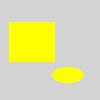

In [37]:
import tempfile
tmp_dir = tempfile.TemporaryDirectory()
path = Path(tmp_dir.name)
create_object_detection(path, size=(100, 100), n_objects=(1, 5), multilabel=True)
print(pd.read_json(path / 'annotations.json').T)
Image.open(list(path.glob('**/images/*'))[2])

In [38]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_base.ipynb.
Converted 00a_annotator.ipynb.
Converted 00b_mltypes.ipynb.
Converted 00c_annotation_types.ipynb.
Converted 00d_doc_utils.ipynb.
Converted 01_bbox_canvas.ipynb.
Converted 01_helpers.ipynb.
Converted 01a_datasets.ipynb.


Converted 01a_datasets_download.ipynb.
Converted 01a_datasets_factory.ipynb.
Converted 01b_dataset_video.ipynb.
Converted 01b_tutorial_image_classification.ipynb.
Converted 01c_tutorial_bbox.ipynb.
Converted 01d_tutorial_video_annotator.ipynb.
Converted 02_navi_widget.ipynb.
Converted 02a_right_menu_widget.ipynb.
Converted 02b_grid_menu.ipynb.


Converted 03_storage.ipynb.
Converted 04_bbox_annotator.ipynb.
Converted 05_image_button.ipynb.
Converted 06_capture_annotator.ipynb.
Converted 07_im2im_annotator.ipynb.
Converted 08_tutorial_road_damage.ipynb.
Converted 09_voila_example.ipynb.
Converted 11_build_annotator_tutorial.ipynb.


Converted 12_debug_utils.ipynb.
Converted 13_datasets_legacy.ipynb.
Converted 14_datasets_factory_legacy.ipynb.
Converted 15_coordinates_input.ipynb.
Converted 16_custom_buttons.ipynb.
Converted 17_annotator_explorer.ipynb.
Converted 18_bbox_trajectory.ipynb.
Converted 19_bbox_video_annotator.ipynb.
Converted 20_image_classification_user_story.ipynb.
Converted index.ipynb.
